A lot of interesting data augmentation ideas here. I think this will be useful code to revisit if it is decided that this is a fruitful avenue to adapt for increased imaging and analysis throughput.

In [265]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
from scipy.signal import convolve2d
from skimage.measure import block_reduce, find_contours
from matplotlib.patches import Rectangle
from kural_core.models import *
from kural_core.data_processing import *
import pickle
from scipy.misc import imresize

PATH = r'D:\Code\kural_work\movie_generation\data\\'

In [2]:
img_ = Image.open(PATH+'s01_5m_2s_100ms_25p.tif')
nf = img_.n_frames

In [3]:
i = np.arange(143)
t = 115 - 20*(i/(nf-1))
l = 135 - 20*(i/(nf-1))
w = 215 + 40*(i/(nf-1))
h = 225 + 40*(i/(nf-1))

In [4]:
img = []
bounds = []
for f in range(nf):
    img_.seek(f)
    for i in range(1):
        tmp_img = np.asarray(list(img_.getdata())).reshape(512,512)
        if i == 0:
            img.append(tmp_img)
            bounds.append((t[f],l[f],h[f],w[f]))
        if i == 1:
            img.append(np.fliplr(tmp_img))
            bounds.append((t[f],512-l[f]-w[f],h[f],w[f]))
        if i == 2:
            img.append(np.flipud(tmp_img))
            bounds.append((512-t[f]-h[f],l[f],h[f],w[f]))
        if i == 3:
            img.append(np.transpose(tmp_img))
            bounds.append((l[f],t[f],w[f],h[f]))
        if i == 4:
            img.append(np.fliplr(np.flipud(tmp_img)))
            bounds.append((512-t[f]-h[f],512-l[f]-w[f],h[f],w[f]))
        if i == 5:
            img.append(np.transpose(np.fliplr(tmp_img)))
            bounds.append((512-l[f]-w[f],t[f],w[f],h[f]))
        if i == 6:
            img.append(np.transpose(np.flipud(tmp_img)))
            bounds.append((l[f],512-t[f]-h[f],w[f],h[f]))
        if i == 7:
            img.append(np.transpose(np.fliplr(np.flipud(tmp_img))))
            bounds.append((512-l[f]-w[f],512-t[f]-h[f],w[f],h[f]))
        

In [5]:
with open(PATH+'BBox_data.pickle','wb') as f:
    pickle.dump((img,bounds),f)

In [2]:
with open(PATH+'BBox_data.pickle','rb') as f:
    img, bounds = pickle.load(f)

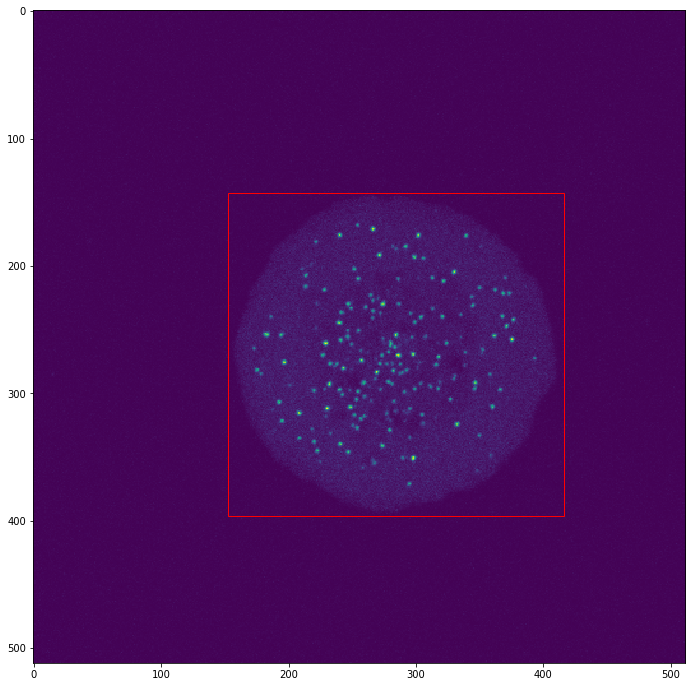

In [129]:
while True:
    idx = np.random.choice(len(img))
    if idx%8==7: break
plt.figure(figsize=[12,12])
plt.imshow(img[idx],origin='upper')
rect = Rectangle(xy=(bounds[idx][1],bounds[idx][0]),width=bounds[idx][3],height=bounds[idx][2],fill=False, edgecolor='r')
ax = plt.gca()
ax.add_patch(rect)
plt.show()

In [66]:
(bounds[idx][1],bounds[idx][0]),bounds[idx][3],bounds[idx][2]

((128.38028169014083, 108.38028169014085),
 228.2394366197183,
 238.2394366197183)

In [5]:
img_tensor = torch.Tensor(np.stack(img))

In [6]:
bounds_tensor = torch.Tensor(np.stack(bounds))

In [7]:
img_set = torch.zeros((50*nf,1,512,512),dtype=torch.float)
bound_set = torch.zeros((50*nf,4),dtype=torch.float)
ds = BBImageDataset(img_tensor,bounds_tensor)
for j in range(50):
    for i in range(len(ds)):
        tmp_img, tmp_bound = ds[i]
        img_set[j*len(ds)+i] = tmp_img/SCALE_FACTOR
        bound_set[j*len(ds)+i] = tmp_bound
        

In [8]:
torch.save(img_set,PATH+'img_set.pt')
torch.save(bound_set,PATH+'bound_set.pt')

In [2]:
img_set = torch.load(PATH+'img_set.pt')
bound_set = torch.load(PATH+'bound_set.pt')

In [14]:
bound_set.shape

torch.Size([7150, 4])

In [262]:
ds = PremodifiedBBImageDataset(img_set,bound_set)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, K=5, rand_seed=42, nORp=1)
bs = 13
train_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
val_dl = torch.utils.data.DataLoader(ds,batch_size=5*bs, sampler=SubsetSampler(val_idx))
model = BoundingBoxModel().cuda()
lr_start = 2e-3
opt = optim.Adam(model.parameters(),lr=2e-3)
train_loss = []
val_loss = []
criterion = nn.MSELoss()

In [263]:
# @do_profile(follow=[AllImageRNNDataset,RandomIndicesForKFoldValidation,SubsetSampler,NFrameModel])
# def profile_fit():
restarts = 1

lr_end = 1e-3
for restart in range(restarts):
    cycles = 1
    epochs = 5
    print(f'restart number {restart+1} out of {restarts}')
#     if len(train_loss)>0: opt = optim.SGD(model.parameters(),lr=lr_start,momentum=0.9)
    # lr_div = (lr_start/lr_end)**(1/epochs)
    time_list = []
    epoch_time_list = None
    cycle_print_str = 'Cycle: 0 ~ Remaining total: Unknown'
    print(cycle_print_str,end='')
    for cycle in range(cycles):
        ts = time.clock()
        if cycle>0: epochs = epochs*2
        lr_start = lr_start*(0.999)**cycle
        epoch_print_str = f' ~ Epoch: 0 ~ Remaining in cycle: {(epochs*np.mean(epoch_time_list) if epoch_time_list is not None else 0):.3g}s'
        print(epoch_print_str, end='')
        epoch_time_list = []
        for epoch in range(epochs):
            ets = time.clock()
            opt.param_groups[0]['lr'] = lr_end + 0.5*(lr_start-lr_end)*(1+math.cos(cycle/cycles*np.pi))
    #         lr /= lr_div
            running_loss = 0.0
            model.train()
            for data in train_dl:
                x_train = data[0].cuda()
                y_actual = data[1].cuda()
                opt.zero_grad()
                y_pred = model(x_train)
                loss = criterion(y_pred,y_actual)
                loss.backward()
                opt.step()
                running_loss += loss.item()
            train_loss.append(running_loss/len(train_dl))

            running_loss = 0.0
            model.eval()
            with torch.no_grad():
                for data in val_dl:
                    x_train = data[0].cuda()
                    y_actual = data[1].cuda()
                    y_pred = model(x_train)
                    running_loss += criterion(y_pred,y_actual).item()
                val_loss.append(running_loss/len(val_dl))
            epoch_time_list.append(time.clock()-ets)
            if epoch_print_str: 
                for _ in range(len(epoch_print_str)):
                    print('\b',end='')
            epoch_print_str = f' ~ Epoch: {epoch+1:2d}/{epochs} ~ Remaining in cycle: {(epochs-(epoch+1))*np.mean(epoch_time_list):.3g}s'
            print(epoch_print_str,end='')
        time_list.append(time.clock()-ts)
        if cycle_print_str: 
            for _ in range(len(cycle_print_str)+len(epoch_print_str)):
                print('\b',end='')
        remaining_time = (cycles-(cycle+1))*np.mean(time_list)
        cycle_print_str = f'Cycle: {cycle+1:3d}/{cycles} ~ Remaining total: {int(remaining_time//60)}m {remaining_time%60:02.0f}s'
        print(cycle_print_str,end='')
    for _ in range(len(cycle_print_str)):
                print('\b',end='')
    print(f'Spent {int(sum(time_list)//60)}m {sum(time_list)%60:2.0f}s doing {cycles*epochs} total steps for an average of {sum(time_list)/cycles/epochs:3.1f}s per step.')

torch.save(model.state_dict(),'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\bounding_box_model.pth')

restart number 1 out of 1
Spent 0m 55s doing 5 total steps for an average of 11.0s per step.


In [169]:
p = list(model.parameters())
for i in range(len(p)):
    print(torch.sum(torch.abs(p[i])<1e-4)/p[i].numel())
print('')
for i in range(len(p)):
    print(torch.sum(torch.abs(p[i].grad)<1e-8)/p[i].numel())

tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')

tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')


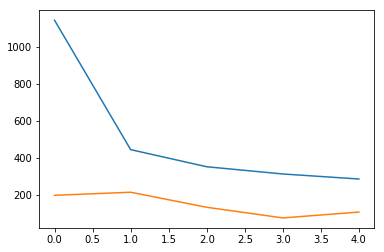

In [264]:
slc = slice(0,len(train_loss))
plt.plot(train_loss[slc])
plt.plot(val_loss[slc])
plt.show()

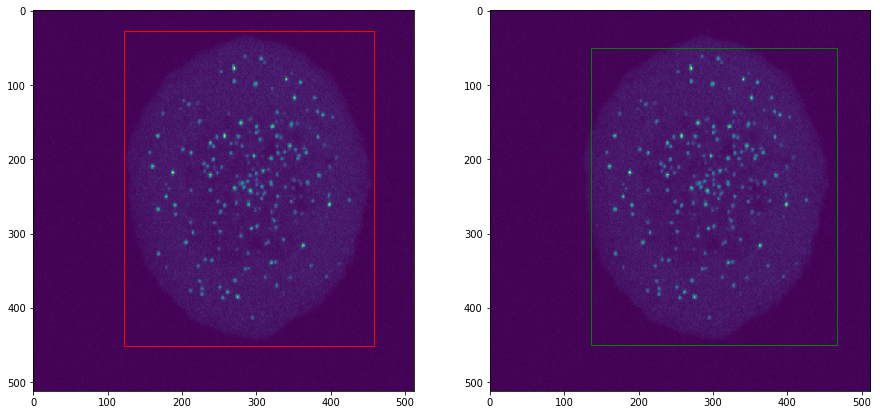

In [247]:
which_idx=train_idx
idx = np.random.choice(which_idx)
fig, ax = plt.subplots(1,2,figsize=[15,10])
plt.imshow(np.zeros((512,512)))
img,bound = ds[idx]
ax[0].imshow(img[0])
rect = Rectangle(xy=(bound[1],bound[0]),width=bound[3],height=bound[2],fill=False, edgecolor='r')
ax[0].add_patch(rect)
ax[1].imshow(img[0])
img = img.cuda()
model.eval()
tmp3 = model(img.view(1,1,512,512)).data.cpu()
rect = Rectangle(xy=(tmp3[0,1],tmp3[0,0]),width=tmp3[0,3],height=tmp3[0,2],fill=False, edgecolor='g')
ax[1].add_patch(rect)
plt.show()

In [499]:
p = list(model.parameters());len(p)

10

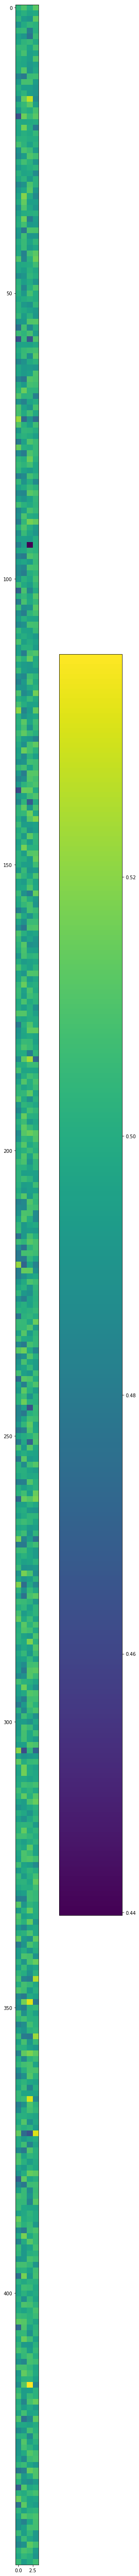

In [412]:
plt.figure(figsize=[16,100])
plt.imshow(torch.transpose(nn.Sigmoid()(p[-2]),0,1).data.cpu())
plt.colorbar()


In [341]:
bound

tensor([-468.7887,  439.9296,  224.8592,  234.8592])

In [63]:
idx = np.random.choice(len(ds))
img = ds[idx][0].cuda()/SCALE_FACTOR
model(img.view(1,1,512,512))

tensor([[112.1219, 132.2314, 231.9879, 221.5788]], device='cuda:0',
       grad_fn=<MulBackward0>)

In [17]:
img_ = Image.open(PATH+'s04_32m_4s_50ms_100p.tif')
nf = img_.n_frames

In [47]:
from scipy.ndimage import zoom

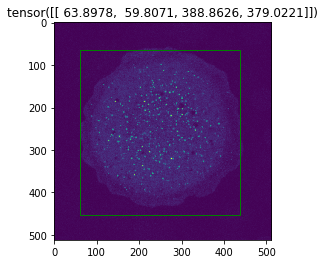

In [261]:
idx = np.random.choice(range(nf))
img_.seek(idx)
tmp_img = np.asarray(list(img_.getdata())).reshape(512,512)

tmp_img_tensor = torch.Tensor(tmp_img).view(1,1,512,512).cuda()/SCALE_FACTOR
model.train()
tmp3 = model(tmp_img_tensor).data.cpu()
plt.imshow(tmp_img)
rect = Rectangle(xy=(tmp3[0,1],tmp3[0,0]),width=tmp3[0,3],height=tmp3[0,2],fill=False, edgecolor='g')
ax = plt.gca()
ax.add_patch(rect)
ax.set_title(f'{tmp3}')
plt.show()

In [310]:
tmp = np.linspace(0,1,10)

In [313]:
tmp

array([0.22222, 0.11111, 0.     , 0.33333, 0.44444, 0.55556, 0.66667, 0.77778, 0.88889, 1.     ])

In [328]:
tmp = torch.Tensor(np.random.randint(0,4,(4,)))

In [409]:
np.random.randint(3.4,6)

4

In [477]:
tmp = model(tmp_img_tensor)
tmp.shape

torch.Size([1, 4])

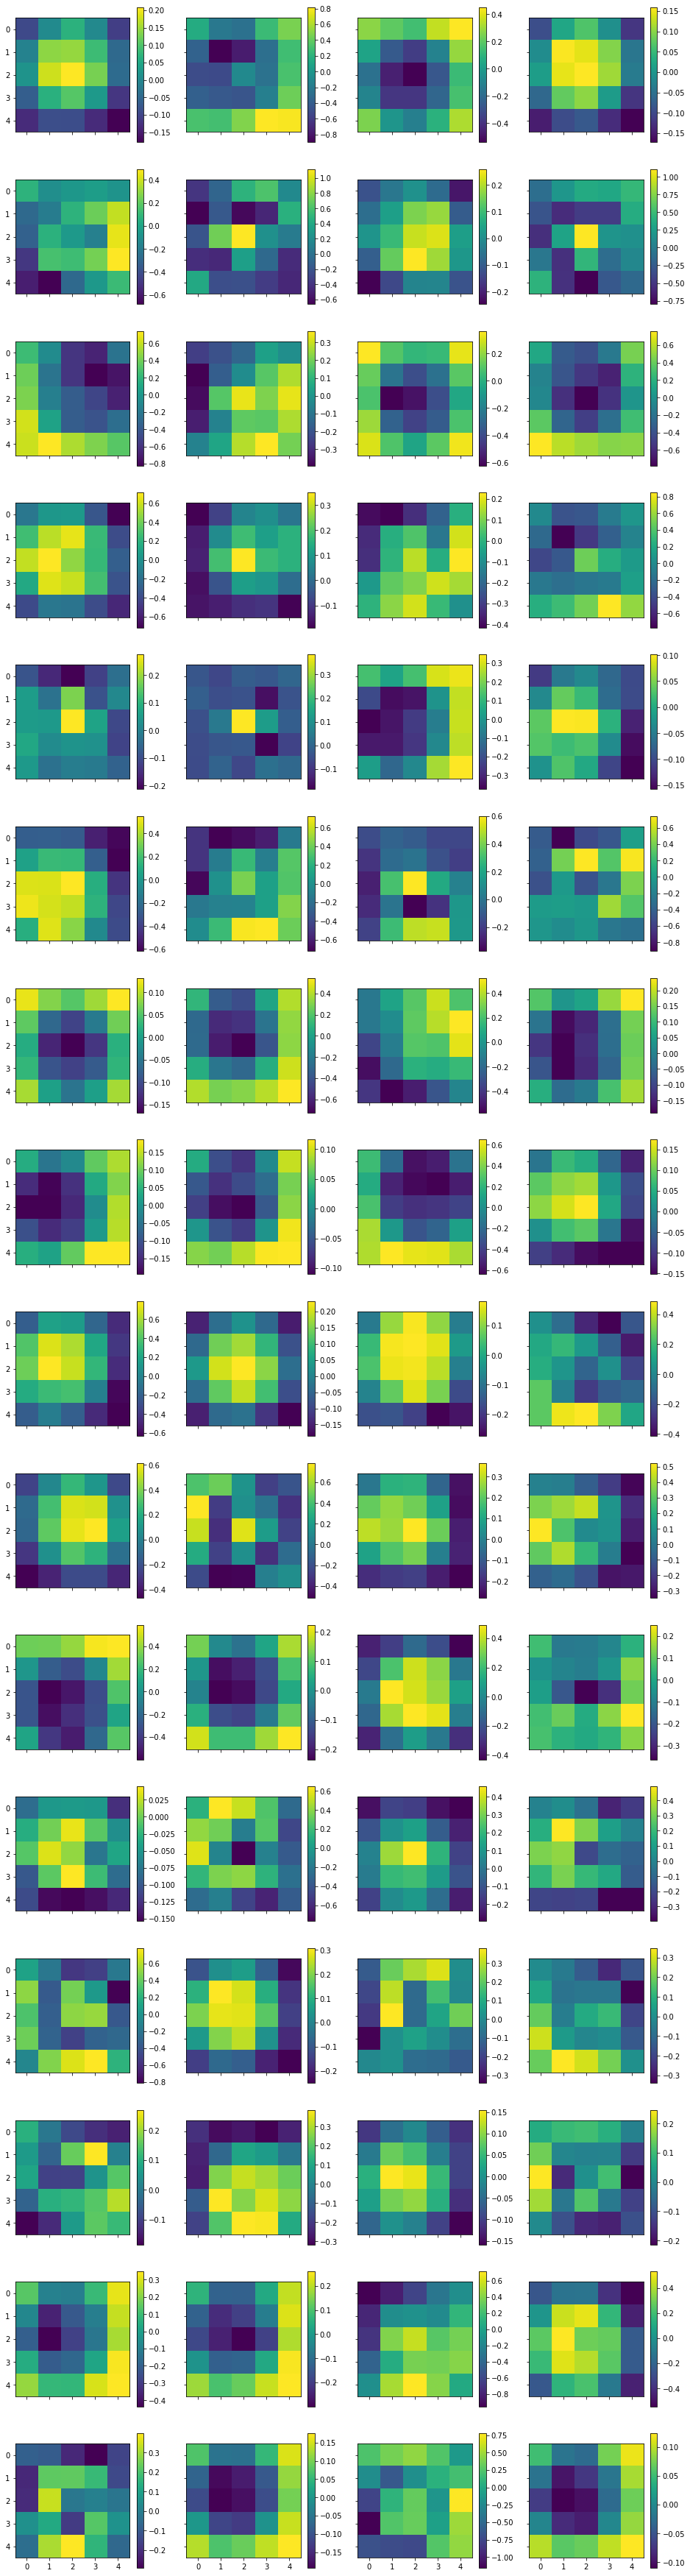

In [425]:
fig, ax = plt.subplots(16,4,sharex=True,sharey=True,figsize=[16,64])
for i in range(16):
    for j in range(4):
        mappable = ax[i,j].imshow(tmp[0,4*i+j].data.cpu())
        plt.colorbar(mappable=mappable,ax=ax[i,j])

In [432]:
model.regression[1].weight.data.shape

torch.Size([80, 1600])

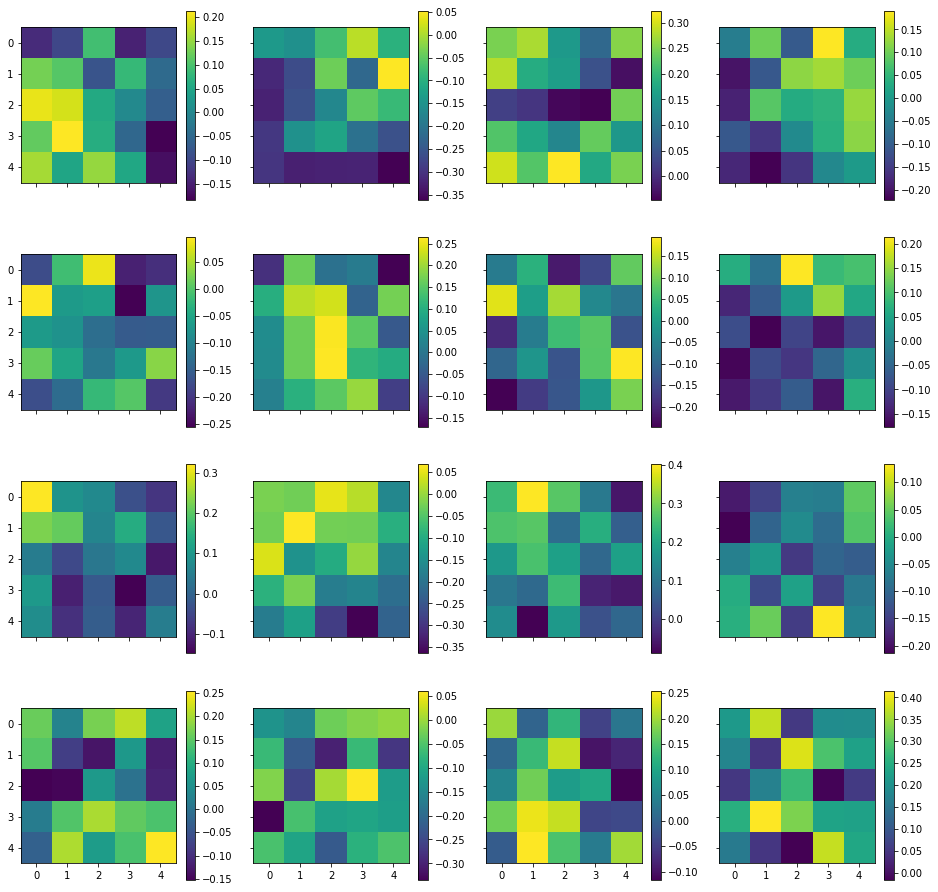

In [430]:
wpb = model.convolution[1].weight.data+model.convolution[1].bias.data.view(16,1,1,1)
fig, ax = plt.subplots(4,4,sharex=True,sharey=True,figsize=[16,16])
for i in range(4):
    for j in range(4):
        mappable = ax[i,j].imshow(wpb[4*i+j,0].data.cpu())
        plt.colorbar(mappable=mappable,ax=ax[i,j])

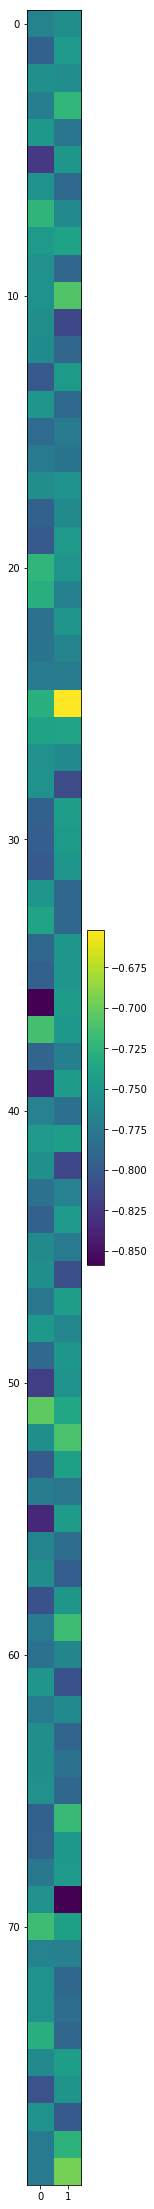

In [445]:
wpb = model.regression[4].weight.data+model.regression[4].bias.data.view(4,1)
plt.figure(figsize=[2,40])
plt.imshow(torch.transpose(wpb,0,1)[:,:2].data.cpu())
plt.colorbar()